<a href="https://www.kaggle.com/code/zhichaocheng/bank-churn-classification-xgb-lgbm-ensemble?scriptVersionId=160603967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Data visualisation
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE # oversampling techinque for imbalance

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv
/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


# Exploratory Data Analysis

Before starting, we import the training data provided for the competition plus the original dataset from which the former is generated from. 

Let's take a look at the first few rows of the provided dataset.

In [45]:
train = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv", index_col="id")
orig_data = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv",index_col = "RowNumber")
orig_data.dropna(inplace=True)
train = pd.concat([train,orig_data])
train.reset_index(drop=True,inplace=True)

test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [46]:
train

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [47]:
train.shape

(175032, 13)

The training data contains 175 032 rows and 13 columns as follows. The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Customer Churn Prediction dataset. (Taken from https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction)

Customer ID: A unique identifier for each customer

Surname: The customer's surname or last name

Credit Score: A numerical value representing the customer's credit score

Geography: The country where the customer resides (France, Spain or Germany)

Gender: The customer's gender (Male or Female)

Age: The customer's age.

Tenure: The number of years the customer has been with the bank

Balance: The customer's account balance

NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)

HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)

IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)

EstimatedSalary: The estimated salary of the customer

Exited: Whether the customer has churned (1 = yes, 0 = no)

In [48]:
train = train.drop(columns = ["CustomerId"])
cats=train.select_dtypes(include="object").columns
conts=train.drop(columns = "Exited").select_dtypes(exclude="object").columns

We remove the columns that will not be used as predictors such as the unique customer identifier. Originally, the surnames were removed as well in the first few attempts at classification, however including them has been found to increase the final AUC of ROC of the predictions. 

In [49]:
train.dtypes

Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [50]:
train.isna().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

We check the data and find that there is no missing values.

In [51]:
train.duplicated().sum()

266

There are duplicated Customer IDs probably due to the dataset being augmented, reusing some of the customer IDs in the process. However, there appears to be 123 duplicates out of the 165k rows. 

With surnames included, there are 54 duplicates in all rows.

With original dataset included, there are 266 duplicates in all rows.

Will be ignored for now. Will have to prune before training.

In [52]:
train.describe().iloc[:,3:]

,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,175032.000000,175032.000000,175032.000000,175032.000000,175032.000000,175032.000000
mean,56677.821792,1.553070,0.751188,0.498743,111862.236392,0.211156
std,62982.219148,0.549211,0.432326,0.500000,50815.188500,0.408130
min,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,73214.330000,0.000000
50%,0.000000,2.000000,1.000000,0.000000,116969.730000,0.000000
75%,120727.970000,2.000000,1.000000,1.000000,154767.340000,0.000000
max,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


We gather some of the summary of the numeric variables. Most of the values seem evenly distributed at first glance, but the account balances seem very highly skewed to the right. In line with expectations, the majority of users who have inactive accounts while even those users with active accounts may not have a lot of money deposited. 

In [53]:
train.describe(include='object')

,Surname,Geography,Gender
count,175032,175032,175032
unique,2932,3,2
top,Hsia,France,Male
freq,2474,99227,98605


In [54]:
train.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [55]:
surnames = train.groupby(by='Surname').Exited.agg(['mean', 'count'])
surnames.sort_values(by=["count"], ascending=False)

,mean,count
Surname,,
Hsia,0.209782,2474
T'ien,0.147391,2300
Hs?,0.225092,1626
Maclean,0.230481,1601
Kao,0.181590,1597
...,...,...
Vance,1.000000,1
McCollum,1.000000,1
McClaran,0.000000,1


In [56]:
surnames.describe()

,mean,count
count,2932.000000,2932.000000
mean,0.217510,59.697135
std,0.189827,166.556956
min,0.000000,1.000000
25%,0.087529,4.000000
50%,0.200000,12.000000
75%,0.300000,34.000000
max,1.000000,2474.000000


Looking at the categorical variables we see there are only users from 3 different countries, France, Spain and Germany. Most of the customers come from France and there are slightly more male customer than females.

For surnames, there are 2932 unique surnames out of the total 175k+ subjects. As far as an aggregated count of Exited customers by surname, it is clear that due the possibility of different customers having the same surname or due to the augmentation of the original data, the probability of Exited differs greatly among customers even with the same surname.

array([[<Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>],
       [<Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>],
       [<Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>]], dtype=object)

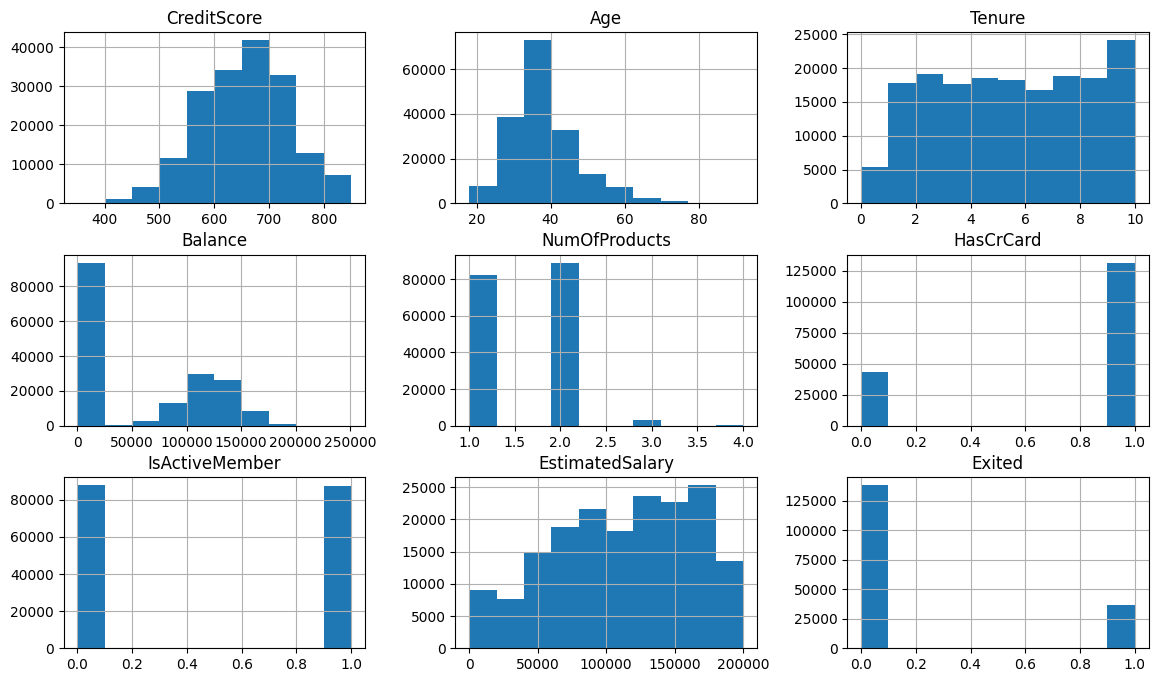

In [57]:
fig, axis = plt.subplots(3, 3,figsize=(14,8))
train.hist(ax=axis)

<Axes: xlabel='Gender'>

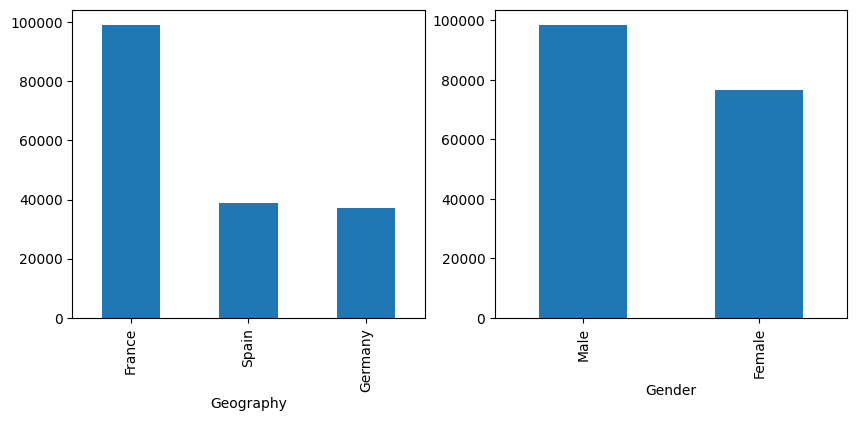

In [58]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
train.Geography.value_counts().plot(kind='bar', ax = ax1)
train.Gender.value_counts().plot(kind='bar' ,ax = ax2)

An overview of the numerical variables once again show that there is a clear uneven distribution of the Exited customers, there being far more non-Exited than Exited customers. The same goes for the number of customers with/without credit cards. 

Majority of customers have \$0 account balance. It may be that they are inactive members. 

Most customers have purchased either 1 or 2 products, with the proportion being almost even. Only a minority purchased 3 or more products.

The other numerical variables seem mostly evenly distributed.

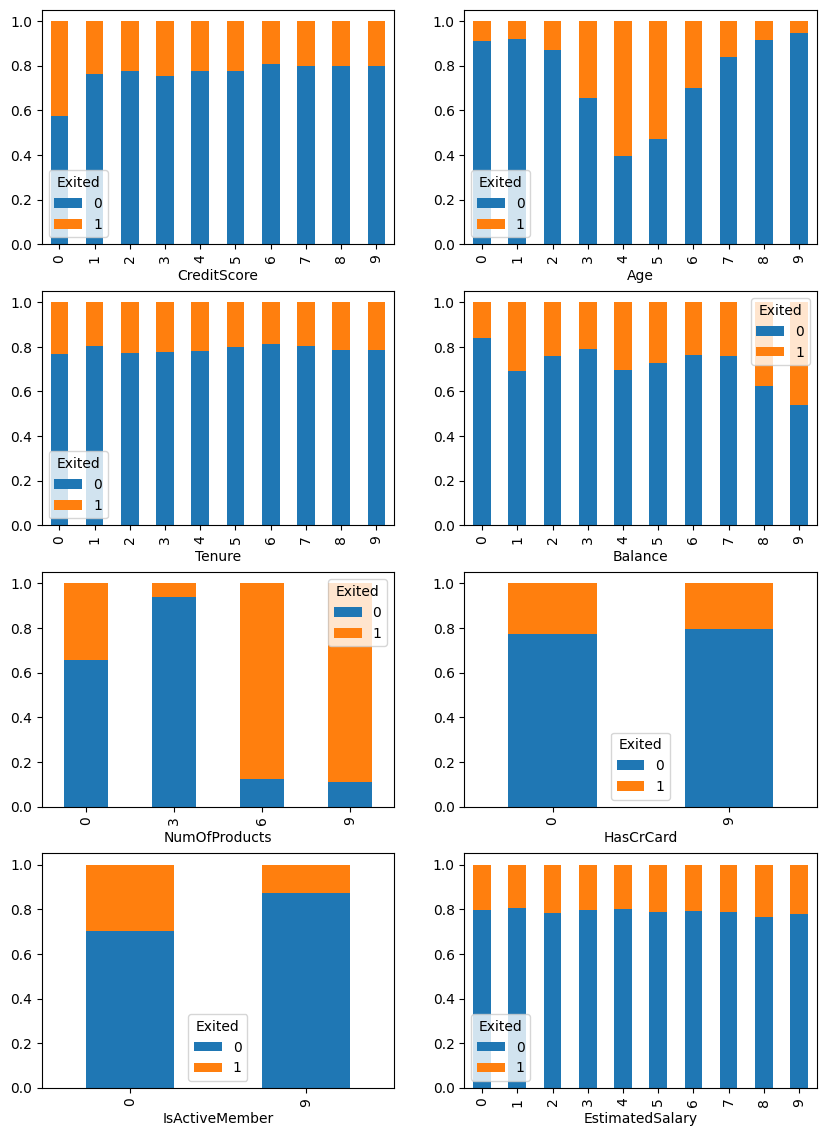

In [59]:
fig, axes = plt.subplots(4,2,figsize=(10,14))
for idx, col in enumerate(conts):
    pd.crosstab(pd.cut(train[col], 
                       bins = 10,
                       include_lowest=True, 
                       labels = False), 
                train.Exited, 
                normalize = "index").plot(kind = 'bar', stacked=True, ax = axes.flatten()[idx])
    axes.flatten()[idx].set(xlabel=col, ylabel=None)

<Axes: xlabel='Gender'>

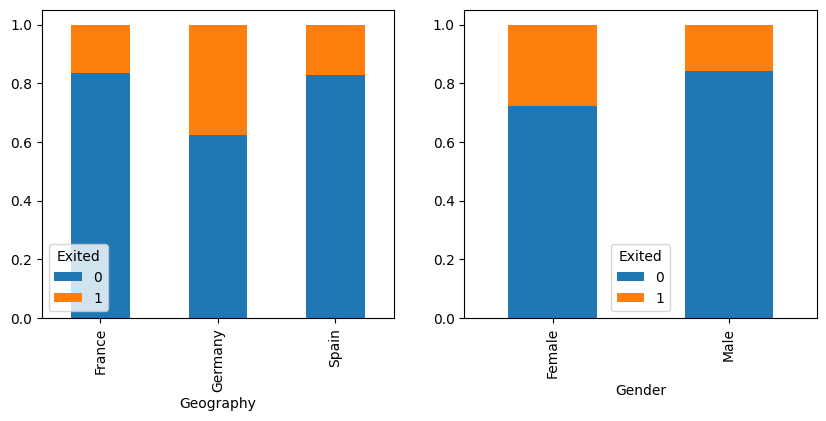

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
pd.crosstab(train.Geography, train.Exited, normalize='index').plot(kind="bar", stacked=True, ax = ax1)
pd.crosstab(train.Gender, train.Exited, normalize='index').plot(kind="bar", stacked=True, ax = ax2)

Using a normalised contingency table we can see that among the variables, the proportion of Exited customers varies mostly by Age, Number of Products they have purchased, and to lesser extents their Geography, Gender and whether they are an ActiveMember or not. 

In [61]:
df = train.groupby(["Exited"]).size()
df/df.sum()*100

Exited
0    78.884433
1    21.115567
dtype: float64

Even from the contingency tables above, it is clear that the dataset is imbalanced, of the total number of test subjects there is only 21.2% of customers who have exited the bank while 78.8% remained. This may affect the training of the model's ability to recognise a client who would have exited over a client who would have stayed. 

In [62]:
df = train.groupby(["HasCrCard"]).size()
df/df.sum()*100

HasCrCard
0.0    24.881165
1.0    75.118835
dtype: float64

The distribution of customers with and without credit cards are largely unevenly split, in a rough 3:1 ratio.

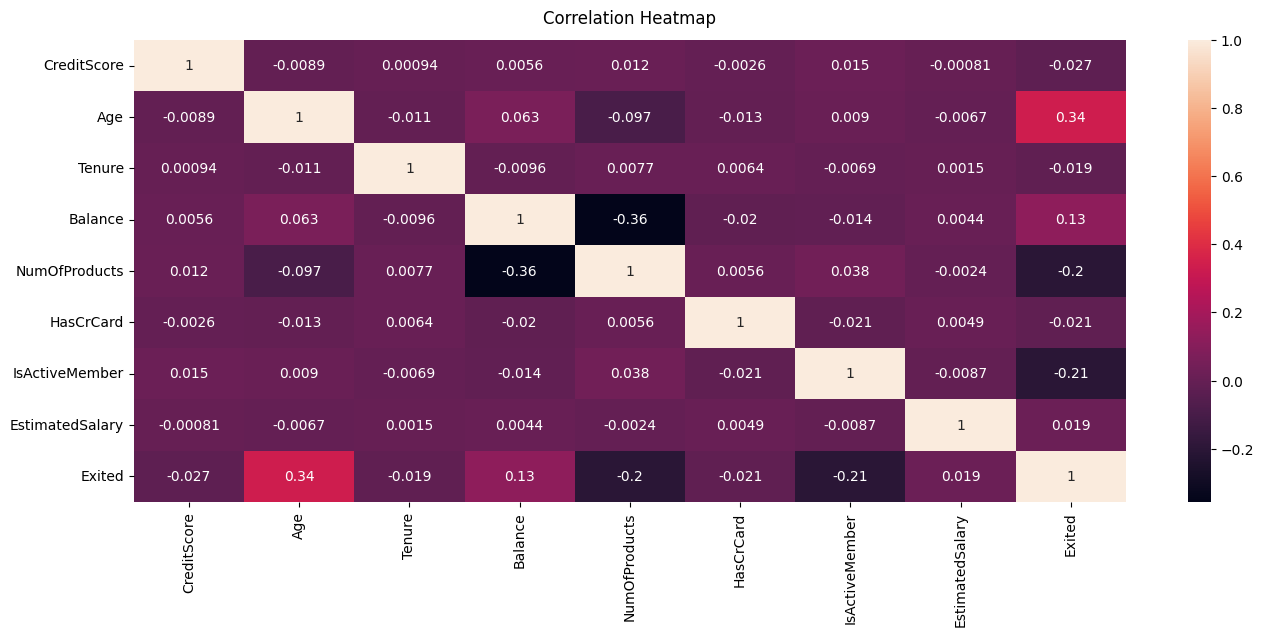

In [63]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train.drop(columns = ["Geography","Gender", "Surname"]).corr(),
                      annot=True);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Most of the variables are not correlated with each other. Age and the probability of Exit is 0.34 which is the highest correlation among all the pairs. Number of products seem slightly correlated to account balance and probability of Exit.

# Preprocessing of Data

In [ ]:
# train = train.head(10000)

To speed up optimisation of the training process we use only the first 10k rows of the dataset.

Update: as of using Hist Gradient Boosting Classifier the speed has improved significantly over the use of RF, hence the full 165k row dataset can be used without much sacrifice in speed.

In [64]:
label_enc = LabelEncoder()

train["Gender"] = label_enc.fit_transform(train.Gender)
test["Gender"] = label_enc.transform(test.Gender)
train["Geography"] = label_enc.fit_transform(train.Geography)
test["Geography"] = label_enc.transform(test.Geography)
train["Surname"] = label_enc.fit_transform(train.Surname)
test["Surname"] = label_enc.transform(test.Surname)
train.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,2023,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,2024,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,1236,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,1362,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,491,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


The Gender, Surname and Geography variables are converted into categorical variables by means of label encoding. 

In [65]:
scaler = MinMaxScaler()
train[conts]  = scaler.fit_transform(train[conts]) 
train.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,2023,0.636,0,1,0.202703,0.3,0.000000,0.333333,1.0,0.0,0.907279,0
1,2024,0.554,0,1,0.202703,0.1,0.000000,0.333333,1.0,1.0,0.247483,0
2,1236,0.656,0,1,0.297297,1.0,0.000000,0.333333,1.0,0.0,0.924364,0
3,1362,0.462,0,1,0.216216,0.2,0.593398,0.000000,1.0,1.0,0.422787,0
4,491,0.732,2,1,0.202703,0.5,0.000000,0.333333,1.0,1.0,0.075293,0


All continuous variables are scaled between a value of 0 and 1. 

In [66]:
x, y = train.drop(columns = ["Exited"]), train.Exited
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state = 45
                                                   )

In [67]:
# Temporarily disabling to test native categorical feature support.

# sm = SMOTE(
#     sampling_strategy='auto',  
#     random_state=42,  
#     k_neighbors=5
# )

# x_train, y_train = sm.fit_resample(x_train, y_train)

# Modeling

## Random Forest

In [70]:
# rf = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",RandomForestClassifier(random_state=42)) ])
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
predictionsrf = rf.predict_proba(x_test)
predictionsrf = predictionsrf[:,1]
accuracy = roc_auc_score(y_test, predictionsrf)
print("Area under ROC:", accuracy)

Area under ROC: 0.8749902565455486


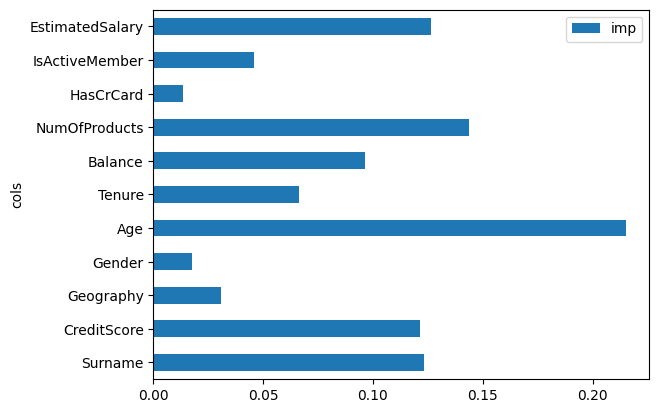

In [71]:
pd.DataFrame(dict(cols=x_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

From the RF we can see the top most important features determining whether or not a customer will Exit is their age, estimated salary and credit score. On the other hand, the least 3 features to likely determine a customer's exit are whether they have a credit card, their gender and geography.

Edit: For better performance in classification and train time taken, XGB and LGBM models are used in the final ensembling, hence the initial results from RF implementation are used as a starting reference point.

## HistGradientBoostingClassifier

In [ ]:
# gb = HistGradientBoostingClassifier(random_state=42, categorical_features=cats)

# gb.fit(x_train, y_train)
# predictions = gb.predict_proba(x_test)
# predictions = predictions[:,1]
# accuracy = roc_auc_score(y_test, predictions)
# print("Area under ROC:", accuracy)

## LGBM Classifier

In [7]:
gb = LGBMClassifier(random_state = 42)

gb.fit(x_train, y_train)
predictions = gb.predict_proba(x_test)
predictions = predictions[:,1]
accuracy = roc_auc_score(y_test, predictions)
print("Area under ROC:", accuracy)

Area under ROC: 0.8912856267152949


In [ ]:
pd.DataFrame(dict(cols=x_train.columns, imp=gb.feature_importances_)).plot('cols', 'imp', 'barh');

In [16]:
def objective_lgb(trial):
    """Define the objective function"""

    params = {
        'n_estimators' : trial.suggest_int('n_estimators',500,2000),
        "max_depth":trial.suggest_int('max_depth',5,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.1, log=True),
        "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
        "min_child_samples" : trial.suggest_int('min_child_samples',1,250),
        "subsample" : trial.suggest_float('subsample', 0.2, 1),
        "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        'num_leaves' : trial.suggest_int('num_leaves', 8, 64),
    }


    model_lgb = LGBMClassifier(**params,random_state=42,device="gpu",gpu_platform_id=0,
              gpu_device_id=0,
              num_threads=4)
    cv = cross_val_score(model_lgb, x, y, cv = 4,scoring='roc_auc').mean()
    return cv

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgb, n_trials=20)

In [18]:
print('Best parameters', study.best_params)

Best parameters {'n_estimators': 1937, 'max_depth': 27, 'learning_rate': 0.01543388898547207, 'min_child_weight': 2.596629676806093, 'min_child_samples': 144, 'subsample': 0.9850128982057416, 'subsample_freq': 1, 'colsample_bytree': 0.7004409694046023, 'num_leaves': 44}


In [22]:
gb = LGBMClassifier(random_state = 42,**study.best_params,device="gpu")

gb.fit(x_train, y_train)
predictions = gb.predict_proba(x_test)
predictions = predictions[:,1]
accuracy = roc_auc_score(y_test, predictions)
print("Area under ROC:", accuracy)

Area under ROC: 0.8926936344597697


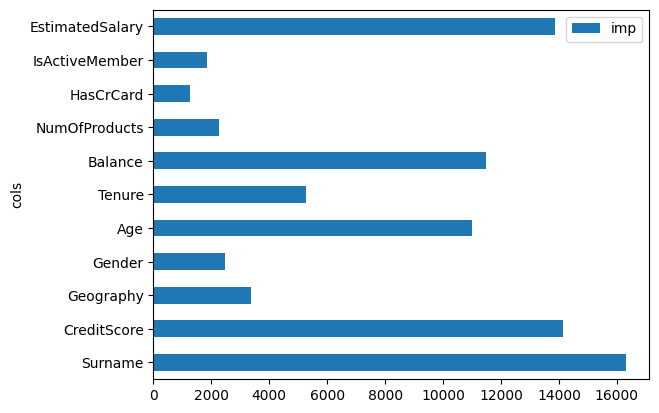

In [24]:
pd.DataFrame(dict(cols=x_train.columns, imp=gb.feature_importances_)).plot('cols', 'imp', 'barh');

First attempt, scikit-learn Random Forest Classifier Area under ROC of 0.743 using roc_auc_score function. 

Second attempt, attempted to stratify data in train_test_split function. Area under ROC is 0.742. Not much difference observed from first attempt.

Made some changes in the code. roc_auc_score function calculated using probabilities instead of predictions. Achieved ROC of 0.873.

Used 4000 sets of data instead of all 165k rows. Managed to achieve ROC of 0.841. 

Used 10k sets end up with ROC about 0.849.

Used smote (still 10k datasets) and ended with AUC of 0.839.

Used smote with all 165k dataset ended up with AUC of 0.872.

Used smote with all dataset, removed the stratify parameter on train_test_split to allow for SMOTE function. Ended up with AUC of 0.871. Not much difference.

StandardScaler used, AUC of 0.871 with RF.
StandardScaler used, AUC of 0.886 with GB (Light GBM), which is also much faster in training. Process is almost instantaneous.

Removed StandardScaler, removed SMOTE, AUC of 0.8888, used native categorical feature support function of HistGradientBoosting.

Same as above, reintroduced SMOTE. Seems to have worsened results slightly. Back to AUC of 0.8862.

Tried to log Balance to evenly distribute the large discrepancy in those without and the remaining users with any bank balance in their own category. Not much noticeable difference.

Attempted ensembling (recorded below in the Test Data section)

Tried LGBM module, AUC of 0.8889

Included surnames as categorical variables using in-built label encoding in pandas (categorical). AUC of 0.8911. 

Included surnames with added data from original source and used labelencoder from scikitlearn preprocessing. AUC: 0.8912856267152949

Used optima for hyperparameter tuning: Area under ROC: 0.8926936344597697

## XGBoost

In [ ]:
xb = XGBClassifier(random_state=42, enable_categorical=True)

xb.fit(x_train, y_train)
predictionsx = xb.predict_proba(x_test)
predictionsx = predictionsx[:,1]
accuracyx = roc_auc_score(y_test, predictionsx)
print("Area under ROC:", accuracyx)

In [ ]:
pd.DataFrame(dict(cols=x_train.columns, imp=xb.feature_importances_)).plot('cols', 'imp', 'barh');

In [32]:
def objective_xgb(trial):
    """Define the objective function"""

    params = {
    'n_estimators' : trial.suggest_int('n_estimators',1500,2500),
    'max_depth':  trial.suggest_int('max_depth',3,8),
    'min_child_weight': trial.suggest_float('min_child_weight', 2,4),
    "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.2),
    'subsample': trial.suggest_float('subsample', 0.2, 1),
    'gamma': trial.suggest_float("gamma", 1e-4, 1.0),
    "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
    "colsample_bylevel" : trial.suggest_float('colsample_bylevel',0.2,1),
    "colsample_bynode" : trial.suggest_float('colsample_bynode',0.2,1),
    }


    xgbopt = XGBClassifier(**params,random_state=42,device = "cuda",eval_metric= "auc")
    cv = cross_val_score(xgbopt, x, y, cv = 4,scoring='roc_auc').mean()
    return cv

In [33]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=20)

[I 2024-01-27 09:17:30,300] A new study created in memory with name: no-name-723382e6-a24f-4696-9d24-8d9019e132f8
[I 2024-01-27 09:17:51,408] Trial 0 finished with value: 0.8858509877231167 and parameters: {'n_estimators': 2411, 'max_depth': 6, 'min_child_weight': 3.794546305192229, 'learning_rate': 0.11777404892172912, 'subsample': 0.20500683060110553, 'gamma': 0.5723438287474896, 'colsample_bytree': 0.29852667112692066, 'colsample_bylevel': 0.21742029404280264, 'colsample_bynode': 0.36549827449818806}. Best is trial 0 with value: 0.8858509877231167.
[I 2024-01-27 09:18:09,764] Trial 1 finished with value: 0.8874427213947619 and parameters: {'n_estimators': 2194, 'max_depth': 6, 'min_child_weight': 3.6259762295658478, 'learning_rate': 0.12439916022230603, 'subsample': 0.5419514397801444, 'gamma': 0.6257572570595091, 'colsample_bytree': 0.20167030517554985, 'colsample_bylevel': 0.5631406756099802, 'colsample_bynode': 0.9864303998188442}. Best is trial 1 with value: 0.8874427213947619.


In [34]:
print('Best parameters', study_x.best_params)

Best parameters {'n_estimators': 2126, 'max_depth': 4, 'min_child_weight': 3.571375612136899, 'learning_rate': 0.01913968047424819, 'subsample': 0.843501398490486, 'gamma': 0.7574412522790698, 'colsample_bytree': 0.8989852795258038, 'colsample_bylevel': 0.7870153425713253, 'colsample_bynode': 0.7411208723266052}


In [37]:
xb = XGBClassifier(random_state = 42,**study_x.best_params,device="cuda",eval_metric= "auc")

xb.fit(x_train, y_train)
predictionsx = xb.predict_proba(x_test)
predictionsx = predictionsx[:,1]
accuracyx = roc_auc_score(y_test, predictionsx)
print("Area under ROC:", accuracyx)

Area under ROC: 0.8923018974984664


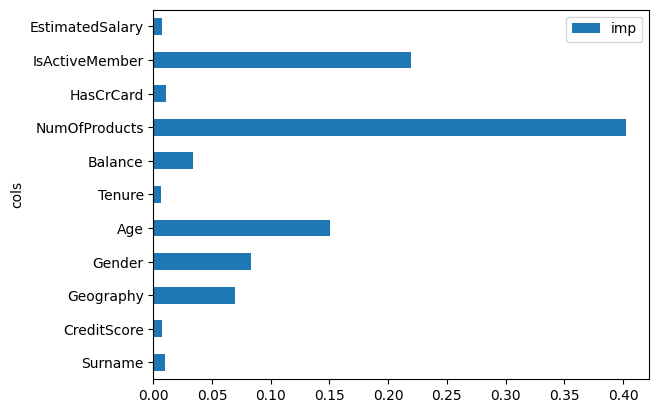

In [38]:
pd.DataFrame(dict(cols=x_train.columns, imp=xb.feature_importances_)).plot('cols', 'imp', 'barh');

# Test Data and Submission

In [ ]:
test.shape

We should copy out a column for the IDs for the test data as it is needed for submission.

In [39]:
ids = pd.DataFrame(test.id)
test = test.drop(columns = ["id","CustomerId"])
test[conts]  = scaler.transform(test[conts]) 
test.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1607,0.472,0,0,0.067568,0.2,0.000000,0.333333,0.0,1.0,0.804903
1,1966,0.666,0,0,0.378378,0.2,0.000000,0.000000,1.0,0.0,0.362723
2,1351,0.612,0,0,0.216216,0.7,0.000000,0.333333,1.0,0.0,0.694419
3,1986,0.662,0,1,0.243243,0.8,0.000000,0.000000,1.0,0.0,0.569654
4,1172,0.804,1,1,0.270270,1.0,0.483318,0.000000,1.0,0.0,0.697164


Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

In [40]:
ens_cv_scores, ens_test_preds = list(), list()

sk = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 45)
for i, (train_idx, test_idx) in enumerate(sk.split(x, y)):
    X_tr, X_va = x.iloc[train_idx], x.iloc[test_idx]
    Y_tr, Y_va = y.iloc[train_idx], y.iloc[test_idx]
    md_lgbm = LGBMClassifier(**study.best_params,device='gpu').fit(X_tr, Y_tr)
    
    md_xgb = XGBClassifier(tree_method="hist", device="cuda",**study_x.best_params,
                           enable_categorical=True).fit(X_tr, Y_tr)
    best_score = 0.0
    best_wei = 0.0
    for wei in np.arange(0.01, 1.0, 0.02):
        fold_pred = (1.0-wei)*md_lgbm.predict_proba(X_va) + wei*md_xgb.predict_proba(X_va)
        fold_score = roc_auc_score(Y_va, fold_pred[:, 1])
        if best_score < fold_score:
            best_score = fold_score
            best_wei = wei
#     best_score2 = 0.0
#     best_wei2 = 0.0
#     for wei in np.arange(0.01, 1.0, 0.02):
#         fold_pred = wei*(best_wei*md_lgbm.predict_proba(X_va)[:,1] + (1.0-best_wei)*md_rf.predict_proba(X_va)[:,1])+(1.0-wei)*md_xgb.predict_proba(X_va)[:,1]
#         fold_score = roc_auc_score(Y_va, fold_pred)
#         if best_score2 < fold_score:
#             best_score2 = fold_score
#             best_wei2 = wei
    ens_cv_scores.append(best_score)
    print('Fold', i+1, '==> Ensemble oof AUC score is ==>', best_score)
    test_pred = (1.0-best_wei)*md_lgbm.predict_proba(test)[:,1]+best_wei*md_xgb.predict_proba(test)[:,1]
    ens_test_preds.append(test_pred)

Fold 1 ==> Ensemble oof AUC score is ==> 0.8949445107265755
Fold 2 ==> Ensemble oof AUC score is ==> 0.8885041840823816
Fold 3 ==> Ensemble oof AUC score is ==> 0.8918266185239832
Fold 4 ==> Ensemble oof AUC score is ==> 0.8930786077047937
Fold 5 ==> Ensemble oof AUC score is ==> 0.8934779851615513
Fold 6 ==> Ensemble oof AUC score is ==> 0.8902677785626651
Fold 7 ==> Ensemble oof AUC score is ==> 0.8901070712923397
Fold 8 ==> Ensemble oof AUC score is ==> 0.8947934979182717
Fold 9 ==> Ensemble oof AUC score is ==> 0.8922066125251104
Fold 10 ==> Ensemble oof AUC score is ==> 0.8911842763896975


Ensembling between XGB and HGBM using stratified 10-fold cross validation. 

Code adapted from: https://www.kaggle.com/code/rockiecao/pss4e1-binaryclassificationbankchurn-ensemble#5.-Feature-Engineering

In [41]:
print('Final oof AUC score is', np.mean(ens_cv_scores))

Final oof AUC score is 0.892039114288737


Attempt 1 for ensembling only.
* Final oof AUC score is 0.8895031375786188

Attempt 2 after using MinMaxScaler to fit_transform train set and transform on test set.
* final oof AUC score is 0.8893412105019184

Attempt 3 after making sure all x are used in 10-fold stratified rather than originally only x_train.
* final oof AUC score is 0.8894640520331359

Attempt 4 made wei the coefficient of XGBoost instead of HGB 
* final oof AUC score is 0.8895200251863056

Attempt 5 used new LGBM with proper hyperparameter tuning ensembled with XGB. 
* final oof AUC score is 0.8898031594743013

Attempt 6 with added surnames with label encoding.
* final oof AUC score is 0.8925373187174838

Attempt 7 with surnames using scikitlearn labelencoder and with added original dataset. 
* final oof AUC score is 0.8915331334395923

Attempt 8 with optuna tuning:
* Final oof AUC score is 0.892039114288737

In [44]:
res = np.mean(ens_test_preds, axis=0)
ids['Exited']=pd.Series(res)
ids.to_csv('submission.csv', index=False)

Saving csv file for submission using average of predictions on test data.